# Financial Analysis of Stocks from Financial News
## Data Overview
This project focuses on the detailed analysis of a large corpus of financial news data to discover correlations between news sentiment and stock market movements.

FNSPID (Financial News and Stock Price Integration Dataset), is a comprehensive financial dataset designed to enhance stock market predictions by combining quantitative and qualitative data.

## 1. Exploratory Data Analysis (EDA)
### a. Load and Inspect Data

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter
import re

In [68]:

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to C:\Users\Surafel
[nltk_data]     Destaw\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package stopwords to C:\Users\Surafel
[nltk_data]     Destaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [69]:
# Load dataset
df = pd.read_csv('../data/raw_analyst_ratings.csv', index_col=0) 
df.head(10)


,headline,url,publisher,date,stock
0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A
5,"CFRA Maintains Hold on Agilent Technologies, L...",https://www.benzinga.com/news/20/05/16095163/c...,vishwanath@benzinga.com,2020-05-22 11:23:25-04:00,A
6,"UBS Maintains Neutral on Agilent Technologies,...",https://www.benzinga.com/news/20/05/16094027/u...,vishwanath@benzinga.com,2020-05-22 09:36:20-04:00,A
7,Agilent Technologies shares are trading higher...,https://www.benzinga.com/wiim/20/05/16093805/a...,Benzinga Newsdesk,2020-05-22 09:07:04-04:00,A
8,Wells Fargo Maintains Overweight on Agilent Te...,https://www.benzinga.com/news/20/05/16093505/w...,vishwanath@benzinga.com,2020-05-22 08:37:59-04:00,A
9,10 Biggest Price Target Changes For Friday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,2020-05-22 08:06:17-04:00,A


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1407328 entries, 0 to 1413848
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   headline   1407328 non-null  object
 1   url        1407328 non-null  object
 2   publisher  1407328 non-null  object
 3   date       1407328 non-null  object
 4   stock      1407328 non-null  object
dtypes: object(5)
memory usage: 64.4+ MB


### b. Descriptive Statistics
#### Headline Lengths:

In [71]:
df['headline_length'] = df['headline'].apply(len)
df['headline_length'].describe()

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64

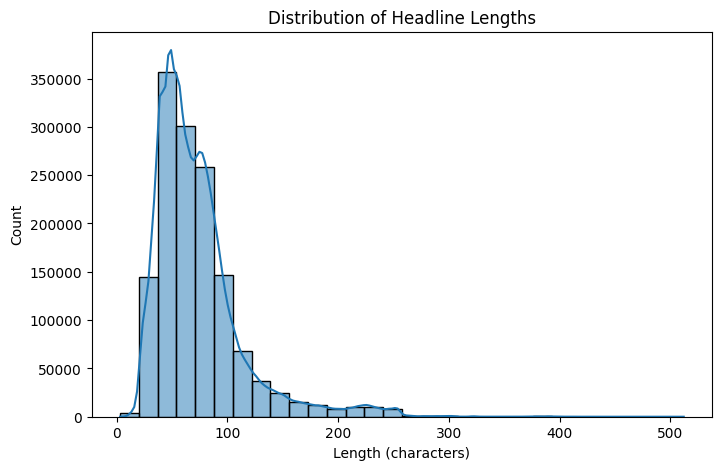

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Length (characters)')
plt.savefig('../notebooks/eda_sentiment_output/headline_length_dist.png')
plt.show()


#### Articles per Publisher:

In [73]:
publisher_counts = df['publisher'].value_counts()
publisher_counts.head(10)

publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64

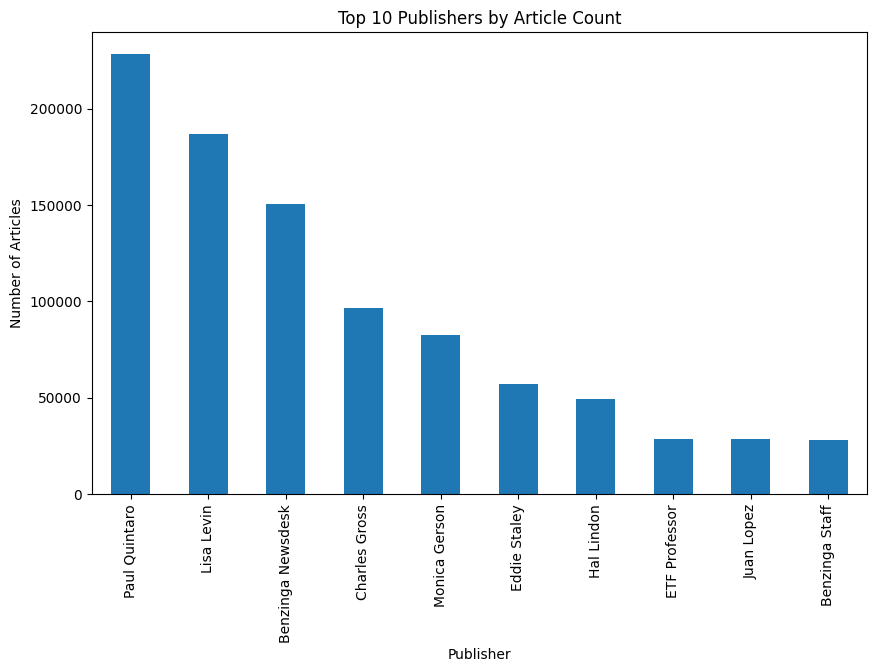

In [ ]:
# Visualize top 10 publishers
plt.figure(figsize=(10, 6))
publisher_counts.head(10).plot(kind='bar')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.savefig('../notebooks/eda_sentiment_output/publisher_counts.png')
plt.show()


#### Publication Date Trends:

In [75]:
df['date'] = pd.to_datetime(df['date'], utc=True, errors='coerce')  # safely handles unexpected values
df['date_only'] = df['date'].dt.date
date_counts = df['date_only'].value_counts().sort_index()

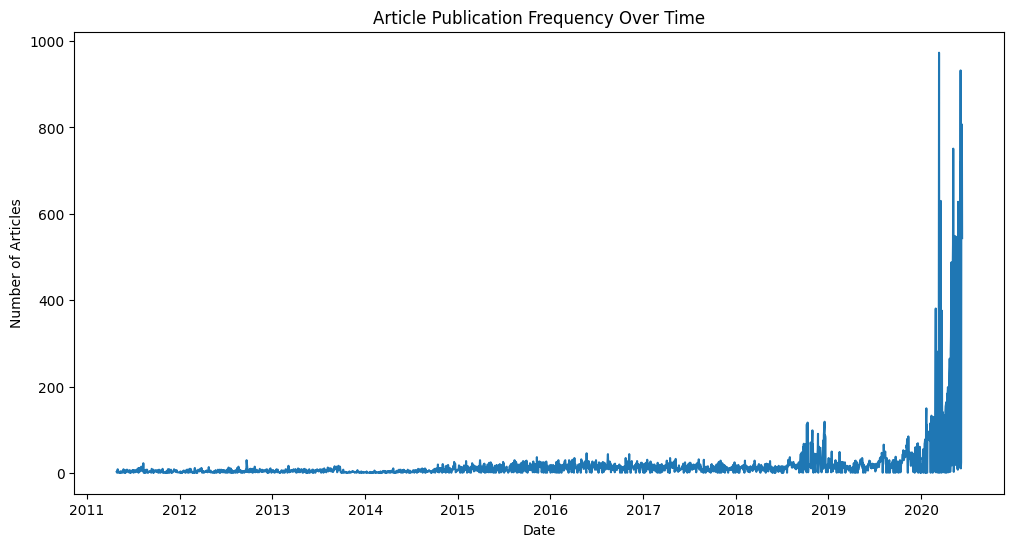

In [ ]:
plt.figure(figsize=(12, 6))
date_counts.plot()
plt.title('Article Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.savefig('../notebooks/eda_sentiment_output/publication_frequency.png')
plt.show()


### c. Text Analysis
#### Sentiment Analysis (using VADER for financial context):

In [77]:
analyzer = SentimentIntensityAnalyzer()
df['sentiment'] = df['headline'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [78]:
# Categorize sentiment
df['sentiment_label'] = df['sentiment'].apply(lambda x: 'positive' if x > 0.05 else 'negative' if x < -0.05 else 'neutral')
print(df['sentiment_label'].value_counts())

sentiment_label
neutral     739338
positive    442930
negative    225060
Name: count, dtype: int64


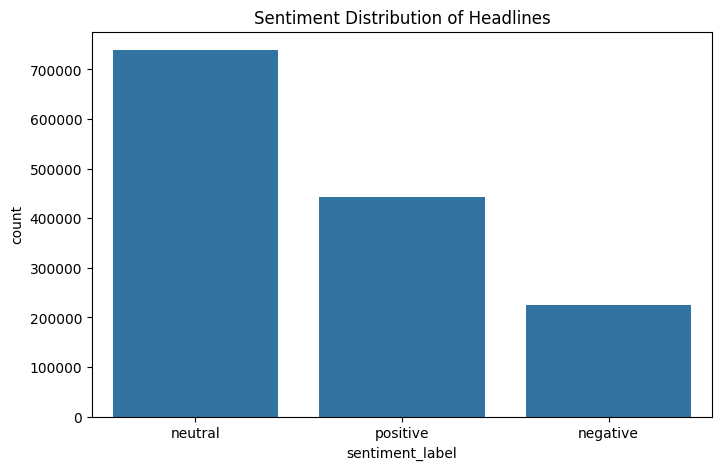

In [ ]:
# Visualize
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=df)
plt.title('Sentiment Distribution of Headlines')
plt.savefig('../notebooks/eda_sentiment_output/sentiment_distribution.png')
plt.show()


#### Topic Modeling (Keyword Extraction):

In [80]:
import nltk.data
print(nltk.data.path)

['C:\\Users\\Surafel Destaw/nltk_data', 'c:\\Users\\Surafel Destaw\\Documents\\Kifya_projects\\W01-Analyzing_Financial_News_Dataset\\venv\\nltk_data', 'c:\\Users\\Surafel Destaw\\Documents\\Kifya_projects\\W01-Analyzing_Financial_News_Dataset\\venv\\share\\nltk_data', 'c:\\Users\\Surafel Destaw\\Documents\\Kifya_projects\\W01-Analyzing_Financial_News_Dataset\\venv\\lib\\nltk_data', 'C:\\Users\\Surafel Destaw\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


In [81]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [82]:
stop_words = set(stopwords.words('english'))

def extract_keywords(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return tokens


In [83]:
all_keywords = df['headline'].apply(extract_keywords).explode()
keyword_counts = Counter(all_keywords)
keyword_counts.most_common(20)

[('stocks', 161702),
 ('vs', 138835),
 ('eps', 128801),
 ('est', 122289),
 ('shares', 114140),
 ('reports', 108688),
 ('update', 91645),
 ('market', 91080),
 ('earnings', 87183),
 ('sales', 79528),
 ('top', 78493),
 ('benzinga', 74466),
 ('pt', 73059),
 ('announces', 66531),
 ('price', 64217),
 ('buy', 63928),
 ('downgrades', 61942),
 ('trading', 61146),
 ('raises', 57793),
 ('upgrades', 56802)]

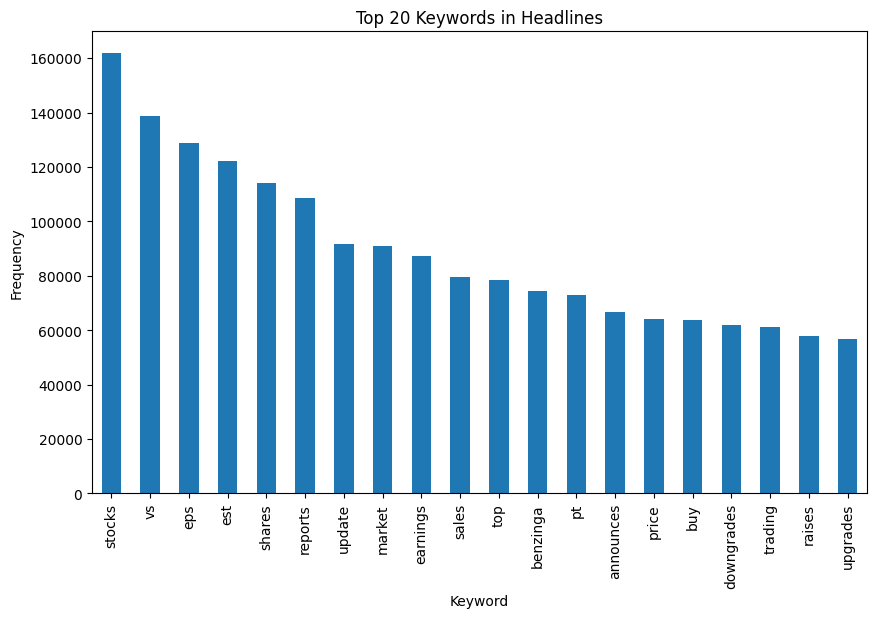

In [ ]:
# Visualize top keywords
plt.figure(figsize=(10, 6))
pd.Series(keyword_counts).nlargest(20).plot(kind='bar')
plt.title('Top 20 Keywords in Headlines')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.savefig('../notebooks/eda_sentiment_output/top_keywords.png')
plt.show()


### d. Time Series Analysis
#### Publication Frequency by Hour:

In [86]:
df['hour'] = df['date'].dt.hour
hour_counts = df['hour'].value_counts().sort_index()

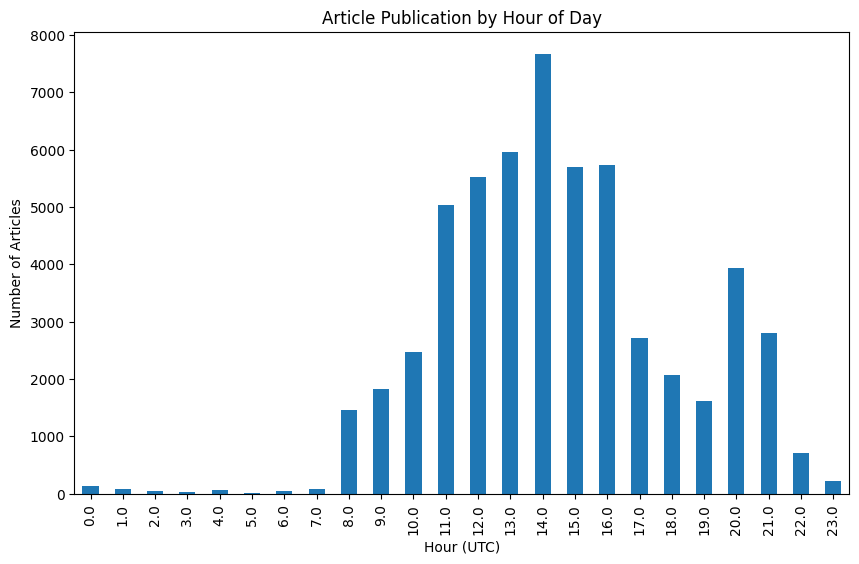

In [ ]:
# Visualize
plt.figure(figsize=(10, 6))
hour_counts.plot(kind='bar')
plt.title('Article Publication by Hour of Day')
plt.xlabel('Hour (UTC)')
plt.ylabel('Number of Articles')
plt.savefig('../notebooks/eda_sentiment_output/hourly_publication.png')
plt.show()


#### Spikes in Publication:

In [90]:
mean_count = date_counts.mean()
std_count = date_counts.std()
spikes = date_counts[date_counts > mean_count + 2 * std_count]
print("Days with publication spikes:", spikes)


Days with publication spikes: date_only
2020-02-27    275
2020-02-28    381
2020-03-06    281
2020-03-11    282
2020-03-12    973
2020-03-19    630
2020-03-23    376
2020-03-24    160
2020-04-09    164
2020-04-13    184
2020-04-15    186
2020-04-16    199
2020-04-17    194
2020-04-20    181
2020-04-21    232
2020-04-22    246
2020-04-23    265
2020-04-24    246
2020-04-27    283
2020-04-28    317
2020-04-29    449
2020-04-30    488
2020-05-01    385
2020-05-04    347
2020-05-05    478
2020-05-06    529
2020-05-07    751
2020-05-08    508
2020-05-11    485
2020-05-12    388
2020-05-13    549
2020-05-14    536
2020-05-15    322
2020-05-18    547
2020-05-19    332
2020-05-20    461
2020-05-21    333
2020-05-22    286
2020-05-26    628
2020-05-27    492
2020-05-28    465
2020-05-29    309
2020-06-01    484
2020-06-02    361
2020-06-03    720
2020-06-04    538
2020-06-05    932
2020-06-08    765
2020-06-09    803
2020-06-10    807
2020-06-11    544
Name: count, dtype: int64


### e. Publisher Analysis
#### Most Active Publishers (already covered in descriptive statistics).
Domain Extraction (if publishers are emails)

In [91]:
def extract_domain(publisher):
    if '@' in publisher:
        return publisher.split('@')[1]
    return publisher

df['publisher_domain'] = df['publisher'].apply(extract_domain)
domain_counts = df['publisher_domain'].value_counts()
print(domain_counts.head(10))

publisher_domain
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


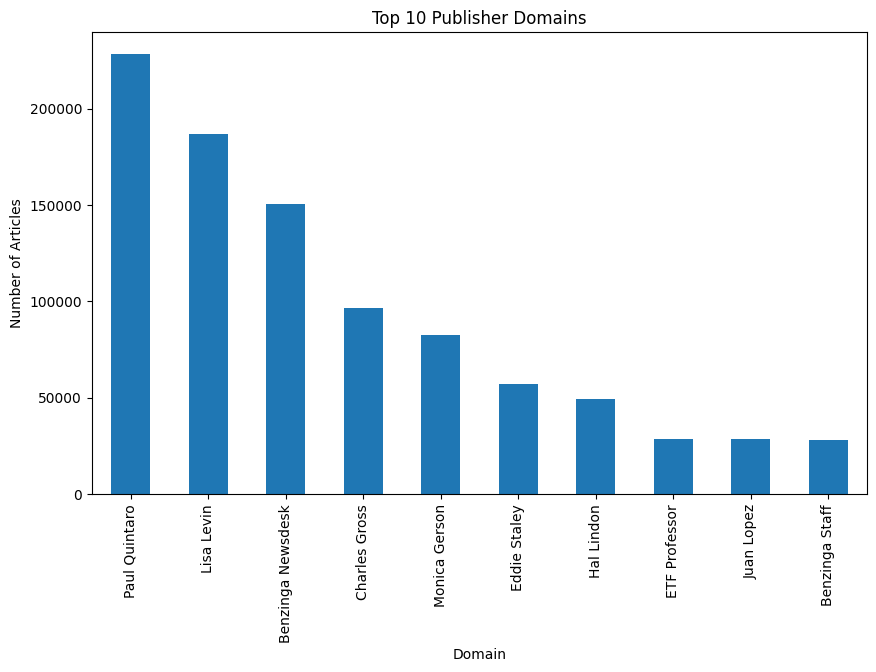

In [ ]:
# Visualize
plt.figure(figsize=(10, 6))
domain_counts.head(10).plot(kind='bar')
plt.title('Top 10 Publisher Domains')
plt.xlabel('Domain')
plt.ylabel('Number of Articles')
plt.savefig('../notebooks/eda_sentiment_output/publisher_domains.png')
plt.show()
